19th Jan, 2022

Linnette Teo
# Model to solve for the thermodynamic equilibrium voltage for a Lithium Sulfur cell (cathode + separator)

Simulates the voltage at each depth-of-discharge (DOD), assuming the cell is at a relaxed, equilibrated state. This is similar to a GITT-relaxation experiment. 

The algebraic equations, solved in three different regions of DOD, can be found in the Julia file ../LiS-thermo-equilibria/LiS_thermo.jl, or the corresponding manuscript for this work (see github readme). 
- Region 1: only S8(s)
- Region 2: no solids
- Region 3: only Li2S(s)



In [1]:
using NLsolve
using PyPlot
using LineSearches
using FileIO
using DelimitedFiles
using DataFrames
using CSV
using LinearAlgebra

include("../LiS-thermo-equilibria/LiS_thermo.jl")

solveThermoAll_S3! (generic function with 1 method)

### Load data - initial guesses for 1% DOD and 99% DOD
- A good initial guess can be obtained from a slow discharge curve. 

- Variable order: CLi, CS8l, CS8m, CS6m, CS4m, CS2m, CSm2, phi1, epcS8/epcLi2S

- Concentrations (C_i), Solid phase voltage or cell voltage (phi1), Volume fraction (epc_k)

- 1% DOD is in region 1, 99% DOD is in region 3, hence variable 9 here refers to epcS8 or epcLi2S respectively

In [2]:
folder_path = "../data/"
df = DataFrame(CSV.File(folder_path*"thermo_initial_guesses.csv", header=1))

,x1,x2
,Float64,Float64
1,1240.59,1096.5
2,19.0,7.81355e-12
3,40.9368,0.000259473
4,74.6953,0.591217
5,4.66292,46.088
6,0.000120608,1.48861
7,1.90694e-7,0.0831727
8,2.38014,2.16765
9,0.149319,0.285781


All variables are log-scaled for more stable solving

In [3]:
x0_1 = log.(df[:,"x1"])
x0_99 = log.(df[:,"x2"]);

### Define parameters

In [4]:
# stoichiometric coefficients, s_ij for species i
# and for electrochemical reaction, j
sLi_1, sS8l_2, sS8m_2, sS8m_3, sS6m_3, sS6m_4, sS4m_4, 
sS4m_5, sS2m_5, sS2m_6, sSm2_6 = 
-1, -1/2, 1/2, -3/2, 2, -1, 3/2, -1/2, 1, -1/2, 1

# reference concentrations (used for initial concentrations in a cell)
CS8lref, CS8mref, CS6mref, CS4mref, CS2mref, CSm2ref, CAref, CS3rref = 
19.0, 0.178, 0.324, 0.02, 5.229E-7, 8.267E-10, 1000, 1.0E-12

# constants
R, T, F, = 8.314, 298, 96487
f = R*T/F

# thermodynamic reaction potentials
U2, U3, U4, U5, U6 = 
2.42, 2.39, 2.25, 2.06, 1.8

# geometric parameters
Lcat, efc, e_S8init = 
100.0E-6, 0.16, 0.24
Lsep, efs = 20.0E-6, 0.0

# solubility and solid  parameters
KspS8, KspLi2S, VS8, VLi2S = 
19.0, 2.0E4, 1.239E-4, 2.768E-5

# initial mol/m^2 of sulfur in the cell
S_bal = ((1-e_S8init-efc)*Lcat + (1-efs)*Lsep) * 
        (CS8lref*8 + CS8mref*8 + CS6mref*6 + CS3rref*3 + 
        CS4mref*4 + CS2mref*2 + CSm2ref*1) + 
        e_S8init/VS8*Lcat*8 
print(S_bal)

# initial charge of system
inichg = ((1-e_S8init-efc)*Lcat + (1-efs)*Lsep) * 
         2*(CS8mref + CS6mref + CS4mref + CS2mref + CSm2ref + CS3rref/2) + 
         1e-7/VLi2S*Lcat*2 

1.5620726439578223

8.424262714895317e-5

## Run solving procedure - base case
- Define step size for dod array from 1% to 99% DOD
- Create empty solution matrix
- Use function from LiS_thermo.jl to solve for equilibria solutions at all DODs

In [5]:
step = 1   # dod step size
ss = findIdx(99,step)
sol_mat = zeros((ss,10))   # create solution_matrix

solveThermoAll!(sol_mat, x0_99, x0_1; step=step)
sol_matbase = sol_mat;
ss0 = ss;

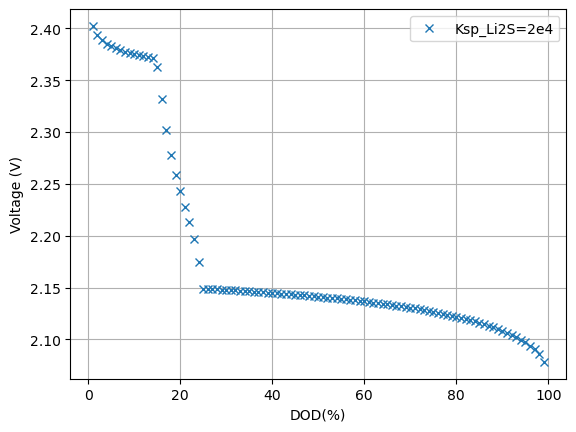

In [6]:
plot(1:ss, sol_mat[1:ss,8], "x", label="Ksp_Li2S=2e4")
ylabel("Voltage (V)")
xlabel("DOD(%)")
legend()
grid()

In [7]:
# CSV.write("thermo_withsep_LT2_Kspx0.01.csv", DataFrame(sol_mat, :auto));

### Add S3 radical chemistry and solve model again
- S6(2-) dissociates to S3(o-)
- KS3 is the reaction equilibrium constant
- a good initial guess for CS3_0 is based on KS3 value
- low values of KS3 (~5e1) means the dissociation reaction is not favored and we see similar results as if the reaction were not turned on 

In [8]:
step = 1               # dod step size
ss = findIdx(99,step)
sol_mat = zeros((ss,11))

KspLi2S = 2.0e4
KS3_mat = [5e1,5e5]    # array of KS3 values to solve for
K3_V_mat = zeros(ss,2)

for (i,Kval) in enumerate(KS3_mat)
    global KS3 = Kval
    global CS3_0 = log(sqrt(KS3*1000))  # initial guess for conc_S3
    
    CS3rref = 1e-4   # initial concentration of CS3 in fully charged cell
    S_bal = ((1-e_S8init-efc)*Lcat + (1-efs)*Lsep) * 
            (CS8lref*8 + CS8mref*8 + CS6mref*6 + CS3rref*3 + 
            CS4mref*4 + CS2mref*2 + CSm2ref*1) + 
            e_S8init/VS8*Lcat*8 
    
    solveThermoAll_S3!(sol_mat, x0_99, x0_1; step=step)
    sol_matS3 = sol_mat
    K3_V_mat[:,i] = sol_mat[:,8]
end
# CSV.write("thermo_withsep_LT2_KS3=5e5.csv", DataFrame(sol_mat, :auto));

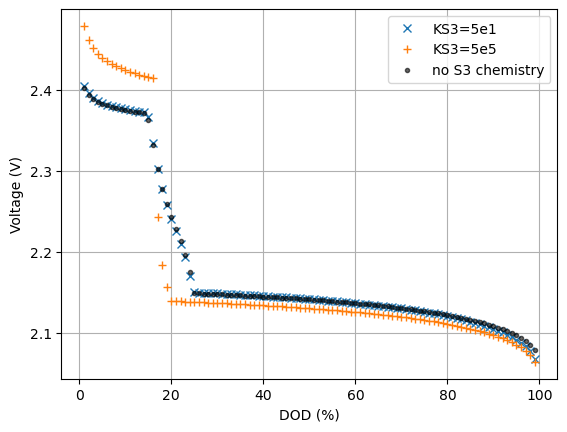

In [9]:
plot(1:ss, K3_V_mat[1:ss,1], "x", label="KS3=5e1")
plot(1:ss, K3_V_mat[1:ss,2], "+", label="KS3=5e5")
plot(1:ss0, sol_matbase[1:ss0,8], "k.", alpha=0.6, label="no S3 chemistry")
xlabel("DOD (%)")
ylabel("Voltage (V)")
legend()
grid()

## Further analysis (that are used in the paper)

### Run solving procedure in a loop, varying KspLi2S

In [10]:
# make sure initial conditions/parameters are reinitialized
CS3rref = 1e-12
S_bal = ((1-e_S8init-efc)*Lcat + (1-efs)*Lsep) * 
        (CS8lref*8 + CS8mref*8 + CS6mref*6 + CS3rref*3 + 
        CS4mref*4 + CS2mref*2 + CSm2ref*1) + 
        e_S8init/VS8*Lcat*8
inichg = ((1-e_S8init-efc)*Lcat + (1-efs)*Lsep) * 
         2*(CS8mref + CS6mref + CS4mref + CS2mref + CSm2ref + CS3rref/2) + 
         1e-7/VLi2S*Lcat*2 

# Varying KspLi2S and storing potentials at various DODs
Ksp_mat = 10 .^(-2.0:0.5:5.6)
U6_mat30 = zeros(length(Ksp_mat))   # voltage at 30% DOD
U6_mat60 = zeros(length(Ksp_mat))
U6_mat90 = zeros(length(Ksp_mat))
R2LB_mat = zeros(length(Ksp_mat))   # region 2 DOD lower bound
R2UB_mat = zeros(length(Ksp_mat))   # region 2 DOD upper bound 

for (i,Ksp) in enumerate(Ksp_mat)
    global KspLi2S = Ksp  
    step = 0.05                     # dod step size
    ss = findIdx(99,step)
    sol_mat = zeros((ss,10))
    R2LB_mat[i], R2UB_mat[i] = solveThermoAll!(sol_mat, x0_99, x0_1; step=step)
    U6_mat30[i] = sol_mat[findIdx(30,step),8]
    U6_mat60[i] = sol_mat[findIdx(60,step),8]
    U6_mat90[i] = sol_mat[findIdx(90,step),8]
end

tieline for equilibrium voltage at 30,60,90% DOD at various values of KspLi2S

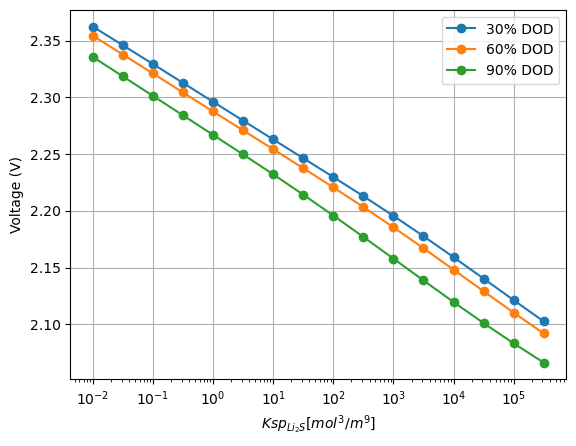

In [11]:
semilogx(Ksp_mat,U6_mat30, "o-", label="30% DOD")
semilogx(Ksp_mat,U6_mat60, "o-", label="60% DOD")
semilogx(Ksp_mat,U6_mat90, "o-", label="90% DOD")
xlabel(L"$Ksp_{Li_2S} [mol^3/m^9]$")
ylabel("Voltage (V)")
legend()
grid()

Window of region 2 (where all polysulfides are dissolved) changes with values of KspLi2S

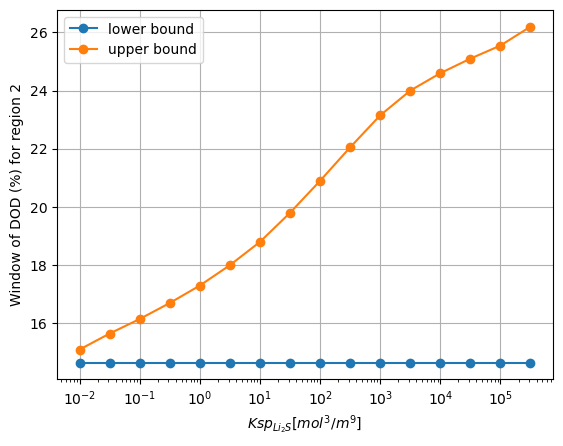

In [12]:
semilogx(Ksp_mat,R2LB_mat, "o-", label="lower bound")
semilogx(Ksp_mat,R2UB_mat, "o-", label="upper bound")
xlabel(L"$Ksp_{Li_2S} [mol^3/m^9]$")
ylabel("Window of DOD (%) for region 2")
legend()
grid()

In [13]:
Ksp_phi_mat = hcat(Ksp_mat, U6_mat30, U6_mat60, U6_mat90)
# CSV.write("KspLi2S_phi_mat.csv", DataFrame(Ksp_phi_mat, :auto));

Ksp_r2bounds_mat = hcat(Ksp_mat, R2LB_mat, R2UB_mat)
# CSV.write("KspLi2S_r2bounds_mat.csv", DataFrame(Ksp_r2bounds_mat, :auto));

### Run solving procedure in a loop, varying KS3

In [14]:
# make sure initial conditions/parameters are reinitialized
KspLi2S = 2.0e4
CS3rref = 1e-4
S_bal = ((1-e_S8init-efc)*Lcat + (1-efs)*Lsep) * 
        (CS8lref*8 + CS8mref*8 + CS6mref*6 + CS3rref*3 + 
        CS4mref*4 + CS2mref*2 + CSm2ref*1) + 
        e_S8init/VS8*Lcat*8
inichg = ((1-e_S8init-efc)*Lcat + (1-efs)*Lsep) * 
         2*(CS8mref + CS6mref + CS4mref + CS2mref + CSm2ref + CS3rref/2) + 
         1e-7/VLi2S*Lcat*2 


# Varying K3 and storing potentials at various DODs
KS3_mat = 10 .^(-2.0:0.5:6)*8
U_mat10 = zeros(length(KS3_mat))
U_mat20 = zeros(length(KS3_mat))
U_mat50 = zeros(length(KS3_mat))
R2LB_mat = zeros(length(KS3_mat))
R2UB_mat = zeros(length(KS3_mat))

for (i,KS3v) in enumerate(KS3_mat)
    global KS3 = KS3v
    global CS3_0 = log(sqrt(KS3*1000))
    step = 0.05
    ss = findIdx(99,step)
    sol_mat = zeros((ss,11))
    
    R2LB_mat[i], R2UB_mat[i] = solveThermoAll_S3!(sol_mat, x0_99, x0_1; step=step)
    U_mat10[i] = sol_mat[findIdx(10,step),8]    
    U_mat20[i] = sol_mat[findIdx(20,step),8]
    U_mat50[i] = sol_mat[findIdx(50,step),8]
end

tieline for equilibrium voltage at 30,60,90% DOD at various values of KS3

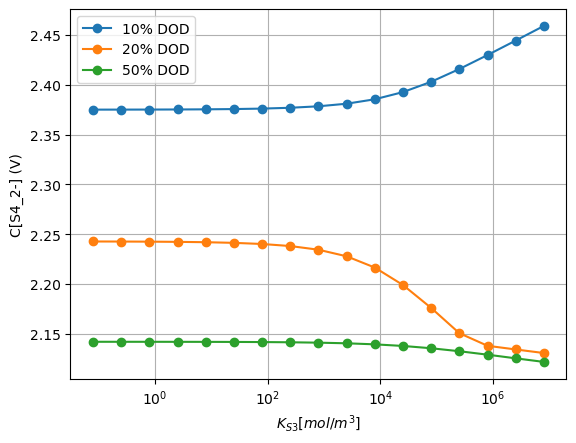

In [15]:
semilogx(KS3_mat,U_mat10, "o-", label="10% DOD")
semilogx(KS3_mat,U_mat20, "o-", label="20% DOD")
semilogx(KS3_mat,U_mat50, "o-", label="50% DOD")

xlabel(L"$K_{S3} [mol/m^3]$")
ylabel("C[S4_2-] (V)")
legend()
grid()

Window of region 2 (where all polysulfides are dissolved) changes with values of KS3

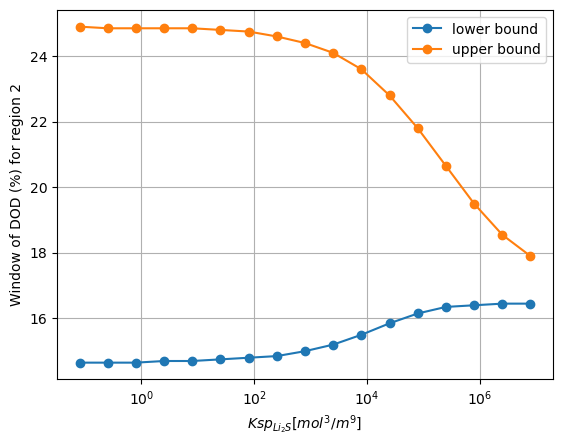

In [16]:
semilogx(KS3_mat,R2LB_mat, "o-", label="lower bound")
semilogx(KS3_mat,R2UB_mat, "o-", label="upper bound")
xlabel(L"$Ksp_{Li_2S} [mol^3/m^9]$")
ylabel("Window of DOD (%) for region 2")
legend()
grid()

In [17]:
KS3_phi_mat = hcat(KS3_mat, U_mat10, U_mat20, U_mat50)
# CSV.write("KS3_phi_mat.csv", DataFrame(KS3_phi_mat, :auto));

KS3_r2bounds_mat = hcat(KS3_mat,R2LB_mat, R2UB_mat)
# CSV.write("KS3_r2bounds_mat.csv", DataFrame(KS3_r2bounds_mat, :auto));